based on https://stackoverflow.com/questions/59381695/lstm-in-pytorch-how-to-add-change-sequence-length-dimension

In [1]:
from fastai.tabular import *
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

# Data preparation

## Get the data

In [2]:
class CryptoDataset:
    """Face Landmarks dataset."""
    TARGET_COLUMN_NAME = 'close'
    DATE_COLUMN_NAME = 'date'
    ELAPSED = 'Elapsed'
    DROP_COLUMNS =['Second', 'Month', 'Year', \
                   'Is_quarter_end', 'Is_quarter_start', \
                   'Is_year_end', 'Is_year_start',
                   'Is_month_end', 'Is_month_start',
                   'Week', 'Dayofyear', ELAPSED]
    True_target_column_name = TARGET_COLUMN_NAME+'_future'

    def __init__(self, csv_file="BTC-ETH-filtered_with_indicators.csv", predict_delta=4, sequence_size=10, batch_size=8):
        """
        Args:
            csv_file (string): Path to the csv file with the crypto stats table.
        """
        from datetime import datetime
        self.sequence_size = sequence_size
        self.df = pd.read_csv("BTC-ETH-filtered_with_indicators.csv",
                              #read dates as dates
                              parse_dates=[self.DATE_COLUMN_NAME],
                              date_parser=lambda x: datetime.fromtimestamp(int(x)))
        add_datepart(self.df, self.DATE_COLUMN_NAME, time=True);
        self.df = self.df.astype(float).drop(columns=self.DROP_COLUMNS)
        self.df[self.True_target_column_name] = self.df[self.TARGET_COLUMN_NAME].shift(-predict_delta)
        trvate_split = tuple(int(x * len(self.df)) for x in (0.75, 0.9, 1.0))
        tmp_train_limit = trvate_split[0]- trvate_split[0]%sequence_size
        self.train_df = self.df[:tmp_train_limit]
        tmp_valid_limit = trvate_split[1] - trvate_split[0]%sequence_size -(trvate_split[1]-trvate_split[0])%sequence_size
        self.valid_df = self.df[tmp_train_limit:tmp_valid_limit]
        self.test_df = self.df[tmp_valid_limit:(len(self.df)- len(self.df)%sequence_size)]
        del tmp_train_limit, tmp_valid_limit
        
        preprocessing_pipeline = Pipeline([("poli-feature", PolynomialFeatures(degree=2)),
                                           ("normalizer", StandardScaler())
                                          ]).fit(self.train_df.input_data(), self.train_df.target())
        temp = preprocessing_pipeline["poli-feature"].get_feature_names(self.train_df.input_data().columns)
        self.train_data = self.__transform_df(self.train_df.input_data(), preprocessing_pipeline, columns=temp)
        self.valid_data = self.__transform_df(self.valid_df.input_data(), preprocessing_pipeline, columns=temp)
        self.test_data = self.__transform_df(self.test_df.input_data(), preprocessing_pipeline, columns=temp)

        del temp

        self.train_data.drop(columns=['1'], inplace=True)
        self.valid_data.drop(columns=['1'], inplace=True)
        self.test_data.drop(columns=['1'], inplace=True)
        
        def create_inout_sequences(input_data: pd.DataFrame, labels: pd.DataFrame, seq_len: int):
            out_labels = torch.tensor(labels.iloc[seq_len-1:].values.astype(np.float32))
            print(input_data.shape)
            out_sequences = np.stack([input_data.iloc[i:i+seq_len] for i in range(len(input_data)-seq_len+1)])
            out_data = torch.tensor(out_sequences.reshape(-1, seq_len, input_data.shape[-1]).astype(np.float32))
#             inout_seq = []
#             L = len(input_data)
#             for i in range(L-seq_len):
#                 train_seq = input_data[i:i+seq_len]
#                 train_label = labels[i+seq_len-1]
# #                 train_label = labels[i+1:i+seq_len+1]
#                 inout_seq.append((torch.from_numpy(train_seq),
#                                   torch.from_numpy(train_label)))
            print(input_data.shape, out_data.shape, out_labels.shape)
            return out_data, out_labels
        
#         train_x_y
        self.train_loader = DataLoader(dataset=TensorDataset(*create_inout_sequences(input_data=self.train_data,
                                                                                    labels=self.train_df.target(),
                                                                                    seq_len=sequence_size)),
                                       batch_size=batch_size, shuffle = True)
        self.val_loader = DataLoader(dataset=TensorDataset(*create_inout_sequences(input_data=self.valid_data,
                                                                                    labels=self.valid_df.target(),
                                                                                    seq_len=sequence_size)),
                                       batch_size=batch_size)
        self.test_loader = DataLoader(dataset=TensorDataset(*create_inout_sequences(input_data=self.test_data,
                                                                                    labels=self.test_df.target(),
                                                                                    seq_len=sequence_size)),
                                       batch_size=batch_size)
#         self.train_loader = create_inout_sequences(input_data=self.train_data,
#                                                    labels=self.train_df.target(),
#                                                    seq_len=sequence_size)
#         self.val_loader = create_inout_sequences(input_data=self.valid_data,
#                                                    labels=self.valid_df.target(),
#                                                    seq_len=sequence_size)
#         self.test_loader = create_inout_sequences(input_data=self.test_data,
#                                                   labels=self.test_df.target(),
#                                                   seq_len=sequence_size)

    def __transform_df(self, df_to_transform, transformer, columns):
        return pd.DataFrame(transformer.transform(df_to_transform), columns=columns)
    
def input_data(self: pd.DataFrame):
    return self.drop(columns=[CryptoDataset.True_target_column_name])
def target(self: pd.DataFrame):
    return self[[CryptoDataset.True_target_column_name]]

pd.DataFrame.input_data = input_data
pd.DataFrame.target = target

### Check for NANs

In [14]:
# [(column, sum(df[column].isna())) for column in df.columns]

# Train

In [3]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DEVICE

device(type='cuda')

In [12]:
BATCH_SIZE = 10
SEQUENCE_SIZE = 8
dataset=CryptoDataset(predict_delta=1,
                      batch_size=BATCH_SIZE,
                      sequence_size=SEQUENCE_SIZE)

(1040, 2015)
(1040, 2015) torch.Size([1033, 8, 2015]) torch.Size([1033, 1])
(208, 2015)
(208, 2015) torch.Size([201, 8, 2015]) torch.Size([201, 1])
(144, 2015)
(144, 2015) torch.Size([137, 8, 2015]) torch.Size([137, 1])


## Model

In [5]:
class SentimentNet(nn.Module):
    def __init__(self, features, output_size=1,
#                  embedding_dim=10,
#                  hidden_dim=50,
                 sequence_size=10,
                 n_layers=1,
                 drop_prob=0.5, device=torch.device("cpu")):
        super(SentimentNet, self).__init__()
        
        embedding_dim=features*2
        hidden_dim=features
        
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.device = device
        
        self.liniar = nn.Linear(features, embedding_dim)
        self.bn1 = nn.BatchNorm1d(num_features=sequence_size) # embedding_dim)
        
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=n_layers, dropout=drop_prob, batch_first=True)
#         self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Sequential(nn.Linear(hidden_dim, hidden_dim//2),
                                nn.BatchNorm1d(num_features=hidden_dim//2),
                                nn.Dropout(drop_prob),
                                nn.Tanh(),
                                nn.Linear(hidden_dim//2, output_size))
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).requires_grad_().to(self.device)
        # Initialize cell state
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).requires_grad_().to(self.device)
        
        out = self.liniar(x)
#         print(out.shape)
        out = F.relu(self.bn1(out))
#         print(out.shape)
        out, (hn, cn) = self.lstm(out, (h0, c0))
        # Index hidden state of last time step
        out = self.fc(out[:, -1, :])
        
        return out
    
#         liniar = self.liniar(x)
#         liniar = liniar.transpose(1,2)
#         print(liniar.shape)
#         liniar = self.bn1(liniar)
#         liniar = F.relu(liniar)
#         lstm_out, hidden = self.lstm(liniar.view(batch_size, -1, liniar.shape[1]),
#                                      (hidden[0][:,-batch_size:,:], # hidden
#                                       hidden[1][:,-batch_size:,:])) # cell state
#         lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
#         out = self.dropout(lstm_out)
#         out = self.fc(lstm_out)
#         out = out.view(batch_size, -1)
#         out = out[:,-1]
        
    
#     def init_hidden(self, batch_size):
#         weight = next(self.parameters()).data
        
#         hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device), # hidden
#                   weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device)) # cell state
#         return hidden

In [6]:
features_count = dataset.train_data.shape[1]
# output_size = 1
# embedding_dim = 400
# hidden_dim = 512
# n_layers = 2

model = SentimentNet(features_count, device=DEVICE, n_layers=3, sequence_size=SEQUENCE_SIZE)
model.to(DEVICE)

lr=0.001
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

epochs = 100
counter = 0
print_every = 5
clip = 5
valid_loss_min = np.Inf
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
                                                   steps_per_epoch=len(dataset.train_loader),
                                                   epochs=epochs)

In [ ]:
# torch.stack([torch.Tensor([[1,1],[2,2]]), torch.Tensor([[1,1],[2,2]])], dim=1)


In [8]:
# def loader_batch_iterator(loader, batch_size):
#     for index in range(0, len(loader), batch_size):
#         batch = loader[index:index+batch_size]
#         yield torch.stack([a for (a,_) in batch], dim=0), torch.stack([b for (_,b) in batch], dim=0)

In [33]:
# def loader_batch_iterator(loader, batch_size):
#     for index in range(0, len(loader), batch_size):
#         batch = loader[index:index+batch_size]
#         yield batch

In [36]:
# for i in loader_batch_iterator(dataset.train_loader, 2):
#     print(len(i), type(i[0]))
#     break

2 <class 'tuple'>


In [ ]:
model.train()

for epoch in range(epochs):
    for train, train_target in dataset.train_loader:
        counter += 1
        # Load data as a torch tensor with gradient accumulation abilities
        train = train.requires_grad_().to(DEVICE)
        train_target = train_target.to(DEVICE)
#         print(train.shape)
#         print(train_target.shape)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        # Forward pass to get output/logits
        outputs = model(train)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, train_target)

        # Getting gradients w.r.t. parameters
        loss.backward()
        # Updating parameters
#         nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        lr_scheduler.step()
        
        # evaluate every x iterations. save model if val error decreased
    
        if counter%print_every == 0:
            #start eval mode
            model.eval()
            val_losses = []
            
            for val_in, val_out in dataset.val_loader:
                # Forward pass to get output/logits
                val_in = val_in.to(DEVICE)
                val_out = val_out.to(DEVICE)
                outputs = model(val_in)
                val_loss = criterion(outputs, val_out)
                val_losses.append(val_loss.item())
            
            print("Epoch: {}/{}...".format(epoch+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if np.mean(val_losses) < valid_loss_min:
                torch.save(model.state_dict(), './state_dict2.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)
                
            # back to train mode
            model.train()

Epoch: 1/100... Step: 5... Loss: 0.324168... Val Loss: 0.047920
Validation loss decreased (inf --> 0.047920).  Saving model ...
Epoch: 1/100... Step: 10... Loss: 0.303344... Val Loss: 0.052943
Epoch: 1/100... Step: 15... Loss: 0.411094... Val Loss: 0.062141
Epoch: 1/100... Step: 20... Loss: 0.422241... Val Loss: 0.044165
Validation loss decreased (0.047920 --> 0.044165).  Saving model ...
Epoch: 1/100... Step: 25... Loss: 0.371759... Val Loss: 0.033374
Validation loss decreased (0.044165 --> 0.033374).  Saving model ...
Epoch: 1/100... Step: 30... Loss: 0.398708... Val Loss: 0.047807
Epoch: 1/100... Step: 35... Loss: 0.345631... Val Loss: 0.033605
Epoch: 1/100... Step: 40... Loss: 0.319120... Val Loss: 0.042294
Epoch: 1/100... Step: 45... Loss: 0.340998... Val Loss: 0.055232
Epoch: 1/100... Step: 50... Loss: 0.177502... Val Loss: 0.046250
Epoch: 1/100... Step: 55... Loss: 0.232690... Val Loss: 0.097165
Epoch: 1/100... Step: 60... Loss: 0.173507... Val Loss: 0.205128
Epoch: 1/100... Ste

Epoch: 6/100... Step: 605... Loss: 0.198763... Val Loss: 0.066868
Epoch: 6/100... Step: 610... Loss: 0.199719... Val Loss: 0.048939
Epoch: 6/100... Step: 615... Loss: 0.147748... Val Loss: 0.077249
Epoch: 6/100... Step: 620... Loss: 0.242438... Val Loss: 0.099791
Epoch: 7/100... Step: 625... Loss: 0.213605... Val Loss: 0.129008
Epoch: 7/100... Step: 630... Loss: 0.150674... Val Loss: 0.058448
Epoch: 7/100... Step: 635... Loss: 0.138475... Val Loss: 0.033180
Validation loss decreased (0.033359 --> 0.033180).  Saving model ...
Epoch: 7/100... Step: 640... Loss: 0.173817... Val Loss: 0.062794
Epoch: 7/100... Step: 645... Loss: 0.121376... Val Loss: 0.078223
Epoch: 7/100... Step: 650... Loss: 0.231819... Val Loss: 0.038951
Epoch: 7/100... Step: 655... Loss: 0.165456... Val Loss: 0.089542
Epoch: 7/100... Step: 660... Loss: 0.205182... Val Loss: 0.129791
Epoch: 7/100... Step: 665... Loss: 0.268578... Val Loss: 0.116055
Epoch: 7/100... Step: 670... Loss: 0.209384... Val Loss: 0.028838
Validat

Epoch: 12/100... Step: 1195... Loss: 0.139851... Val Loss: 0.049048
Epoch: 12/100... Step: 1200... Loss: 0.178603... Val Loss: 0.149265
Epoch: 12/100... Step: 1205... Loss: 0.138765... Val Loss: 0.071863
Epoch: 12/100... Step: 1210... Loss: 0.095716... Val Loss: 0.091416
Epoch: 12/100... Step: 1215... Loss: 0.128191... Val Loss: 0.112525
Epoch: 12/100... Step: 1220... Loss: 0.131953... Val Loss: 0.064481
Epoch: 12/100... Step: 1225... Loss: 0.099120... Val Loss: 0.043418
Epoch: 12/100... Step: 1230... Loss: 0.108325... Val Loss: 0.039863
Epoch: 12/100... Step: 1235... Loss: 0.125691... Val Loss: 0.057157
Epoch: 12/100... Step: 1240... Loss: 0.089378... Val Loss: 0.020587
Validation loss decreased (0.021515 --> 0.020587).  Saving model ...
Epoch: 12/100... Step: 1245... Loss: 0.112782... Val Loss: 0.026378
Epoch: 13/100... Step: 1250... Loss: 0.122568... Val Loss: 0.172658
Epoch: 13/100... Step: 1255... Loss: 0.135719... Val Loss: 0.100417
Epoch: 13/100... Step: 1260... Loss: 0.114765..

Epoch: 18/100... Step: 1775... Loss: 0.038782... Val Loss: 0.017086
Epoch: 18/100... Step: 1780... Loss: 0.035577... Val Loss: 0.002637
Validation loss decreased (0.006809 --> 0.002637).  Saving model ...
Epoch: 18/100... Step: 1785... Loss: 0.067584... Val Loss: 0.075501
Epoch: 18/100... Step: 1790... Loss: 0.055040... Val Loss: 0.058754
Epoch: 18/100... Step: 1795... Loss: 0.018721... Val Loss: 0.073136
Epoch: 18/100... Step: 1800... Loss: 0.066481... Val Loss: 0.072381
Epoch: 18/100... Step: 1805... Loss: 0.089317... Val Loss: 0.153746
Epoch: 18/100... Step: 1810... Loss: 0.061488... Val Loss: 0.151199
Epoch: 18/100... Step: 1815... Loss: 0.062671... Val Loss: 0.072392
Epoch: 18/100... Step: 1820... Loss: 0.034112... Val Loss: 0.002036
Validation loss decreased (0.002637 --> 0.002036).  Saving model ...
Epoch: 18/100... Step: 1825... Loss: 0.057615... Val Loss: 0.010952
Epoch: 18/100... Step: 1830... Loss: 0.050272... Val Loss: 0.097258
Epoch: 18/100... Step: 1835... Loss: 0.034114.

Epoch: 23/100... Step: 2365... Loss: 0.059673... Val Loss: 0.025584
Epoch: 23/100... Step: 2370... Loss: 0.092694... Val Loss: 0.188984
Epoch: 23/100... Step: 2375... Loss: 0.039006... Val Loss: 0.103579
Epoch: 23/100... Step: 2380... Loss: 0.030560... Val Loss: 0.110530
Epoch: 23/100... Step: 2385... Loss: 0.069620... Val Loss: 0.113708
Epoch: 23/100... Step: 2390... Loss: 0.086017... Val Loss: 0.081817
Epoch: 24/100... Step: 2395... Loss: 0.036047... Val Loss: 0.033500
Epoch: 24/100... Step: 2400... Loss: 0.054720... Val Loss: 0.037298
Epoch: 24/100... Step: 2405... Loss: 0.045461... Val Loss: 0.170059
Epoch: 24/100... Step: 2410... Loss: 0.040401... Val Loss: 0.208083
Epoch: 24/100... Step: 2415... Loss: 0.078347... Val Loss: 0.193992
Epoch: 24/100... Step: 2420... Loss: 0.098342... Val Loss: 0.178667
Epoch: 24/100... Step: 2425... Loss: 0.043419... Val Loss: 0.183914
Epoch: 24/100... Step: 2430... Loss: 0.133559... Val Loss: 0.072843
Epoch: 24/100... Step: 2435... Loss: 0.062956...

Epoch: 29/100... Step: 2965... Loss: 0.122554... Val Loss: 0.128555
Epoch: 29/100... Step: 2970... Loss: 0.025504... Val Loss: 0.252579
Epoch: 29/100... Step: 2975... Loss: 0.058033... Val Loss: 0.321007
Epoch: 29/100... Step: 2980... Loss: 0.084786... Val Loss: 0.142551
Epoch: 29/100... Step: 2985... Loss: 0.082647... Val Loss: 0.174861
Epoch: 29/100... Step: 2990... Loss: 0.037151... Val Loss: 0.044404
Epoch: 29/100... Step: 2995... Loss: 0.121734... Val Loss: 0.247981
Epoch: 29/100... Step: 3000... Loss: 0.099160... Val Loss: 0.015679
Epoch: 29/100... Step: 3005... Loss: 0.089724... Val Loss: 0.276782
Epoch: 29/100... Step: 3010... Loss: 0.074737... Val Loss: 0.085946
Epoch: 29/100... Step: 3015... Loss: 0.079209... Val Loss: 0.063529
Epoch: 30/100... Step: 3020... Loss: 0.035641... Val Loss: 0.235757
Epoch: 30/100... Step: 3025... Loss: 0.081295... Val Loss: 0.271711
Epoch: 30/100... Step: 3030... Loss: 0.033894... Val Loss: 0.198627
Epoch: 30/100... Step: 3035... Loss: 0.136832...

Epoch: 35/100... Step: 3565... Loss: 0.001754... Val Loss: 0.946979
Epoch: 35/100... Step: 3570... Loss: 0.000990... Val Loss: 1.072097
Epoch: 35/100... Step: 3575... Loss: 0.001719... Val Loss: 0.831513
Epoch: 35/100... Step: 3580... Loss: 0.000762... Val Loss: 0.527716
Epoch: 35/100... Step: 3585... Loss: 0.001312... Val Loss: 0.339444
Epoch: 35/100... Step: 3590... Loss: 0.001565... Val Loss: 0.137508
Epoch: 35/100... Step: 3595... Loss: 0.001130... Val Loss: 0.011851
Epoch: 35/100... Step: 3600... Loss: 0.001355... Val Loss: 0.301521
Epoch: 35/100... Step: 3605... Loss: 0.002227... Val Loss: 0.339067
Epoch: 35/100... Step: 3610... Loss: 0.000973... Val Loss: 0.510200
Epoch: 35/100... Step: 3615... Loss: 0.001158... Val Loss: 0.208091
Epoch: 35/100... Step: 3620... Loss: 0.002891... Val Loss: 0.085843
Epoch: 35/100... Step: 3625... Loss: 0.000991... Val Loss: 0.083958
Epoch: 35/100... Step: 3630... Loss: 0.000975... Val Loss: 0.220182
Epoch: 35/100... Step: 3635... Loss: 0.000902...

Epoch: 41/100... Step: 4165... Loss: 0.001702... Val Loss: 1.003687
Epoch: 41/100... Step: 4170... Loss: 0.000905... Val Loss: 1.176785
Epoch: 41/100... Step: 4175... Loss: 0.001452... Val Loss: 1.096623
Epoch: 41/100... Step: 4180... Loss: 0.001061... Val Loss: 0.882006
Epoch: 41/100... Step: 4185... Loss: 0.000896... Val Loss: 0.655103
Epoch: 41/100... Step: 4190... Loss: 0.001264... Val Loss: 0.610017
Epoch: 41/100... Step: 4195... Loss: 0.001785... Val Loss: 0.462044
Epoch: 41/100... Step: 4200... Loss: 0.001630... Val Loss: 0.410846
Epoch: 41/100... Step: 4205... Loss: 0.000754... Val Loss: 0.522999
Epoch: 41/100... Step: 4210... Loss: 0.000887... Val Loss: 0.452077
Epoch: 41/100... Step: 4215... Loss: 0.001489... Val Loss: 0.361367
Epoch: 41/100... Step: 4220... Loss: 0.001280... Val Loss: 0.425781
Epoch: 41/100... Step: 4225... Loss: 0.000933... Val Loss: 0.168128
Epoch: 41/100... Step: 4230... Loss: 0.000754... Val Loss: 0.061945
Epoch: 41/100... Step: 4235... Loss: 0.002342...

Epoch: 46/100... Step: 4760... Loss: 0.001079... Val Loss: 0.072124
Epoch: 46/100... Step: 4765... Loss: 0.000499... Val Loss: 0.209514
Epoch: 46/100... Step: 4770... Loss: 0.001310... Val Loss: 0.150182
Epoch: 46/100... Step: 4775... Loss: 0.000826... Val Loss: 0.193792
Epoch: 46/100... Step: 4780... Loss: 0.000803... Val Loss: 0.288946
Epoch: 47/100... Step: 4785... Loss: 0.000642... Val Loss: 0.222927
Epoch: 47/100... Step: 4790... Loss: 0.000623... Val Loss: 0.142144
Epoch: 47/100... Step: 4795... Loss: 0.000878... Val Loss: 0.028494
Epoch: 47/100... Step: 4800... Loss: 0.001305... Val Loss: 0.149690
Epoch: 47/100... Step: 4805... Loss: 0.000633... Val Loss: 0.189348
Epoch: 47/100... Step: 4810... Loss: 0.000773... Val Loss: 0.140612
Epoch: 47/100... Step: 4815... Loss: 0.001051... Val Loss: 0.107506
Epoch: 47/100... Step: 4820... Loss: 0.000600... Val Loss: 0.045016
Epoch: 47/100... Step: 4825... Loss: 0.000817... Val Loss: 0.027569
Epoch: 47/100... Step: 4830... Loss: 0.000746...

Epoch: 52/100... Step: 5360... Loss: 0.000680... Val Loss: 0.012450
Epoch: 52/100... Step: 5365... Loss: 0.000861... Val Loss: 0.079893
Epoch: 52/100... Step: 5370... Loss: 0.000954... Val Loss: 0.179026
Epoch: 52/100... Step: 5375... Loss: 0.000716... Val Loss: 0.287237
Epoch: 52/100... Step: 5380... Loss: 0.000865... Val Loss: 0.121242
Epoch: 52/100... Step: 5385... Loss: 0.000716... Val Loss: 0.051226
Epoch: 52/100... Step: 5390... Loss: 0.001032... Val Loss: 0.207086
Epoch: 52/100... Step: 5395... Loss: 0.000307... Val Loss: 0.141636
Epoch: 52/100... Step: 5400... Loss: 0.000696... Val Loss: 0.053304
Epoch: 52/100... Step: 5405... Loss: 0.000434... Val Loss: 0.014018
Epoch: 53/100... Step: 5410... Loss: 0.000972... Val Loss: 0.112060
Epoch: 53/100... Step: 5415... Loss: 0.000478... Val Loss: 0.231021
Epoch: 53/100... Step: 5420... Loss: 0.000872... Val Loss: 0.200141
Epoch: 53/100... Step: 5425... Loss: 0.000938... Val Loss: 0.093688
Epoch: 53/100... Step: 5430... Loss: 0.000717...

Epoch: 58/100... Step: 5960... Loss: 0.000625... Val Loss: 0.957975
Epoch: 58/100... Step: 5965... Loss: 0.000549... Val Loss: 0.910072
Epoch: 58/100... Step: 5970... Loss: 0.000434... Val Loss: 0.613073
Epoch: 58/100... Step: 5975... Loss: 0.000633... Val Loss: 0.068861
Epoch: 58/100... Step: 5980... Loss: 0.001013... Val Loss: 0.404757
Epoch: 58/100... Step: 5985... Loss: 0.000460... Val Loss: 0.466498
Epoch: 58/100... Step: 5990... Loss: 0.000566... Val Loss: 0.337570
Epoch: 58/100... Step: 5995... Loss: 0.000261... Val Loss: 0.054986
Epoch: 58/100... Step: 6000... Loss: 0.000663... Val Loss: 0.108802
Epoch: 58/100... Step: 6005... Loss: 0.000857... Val Loss: 0.235969
Epoch: 58/100... Step: 6010... Loss: 0.000624... Val Loss: 0.137000
Epoch: 58/100... Step: 6015... Loss: 0.000485... Val Loss: 0.363015
Epoch: 58/100... Step: 6020... Loss: 0.000501... Val Loss: 0.242792
Epoch: 58/100... Step: 6025... Loss: 0.000576... Val Loss: 0.352972
Epoch: 58/100... Step: 6030... Loss: 0.000520...

Epoch: 64/100... Step: 6560... Loss: 0.000619... Val Loss: 0.401217
Epoch: 64/100... Step: 6565... Loss: 0.000374... Val Loss: 0.396127
Epoch: 64/100... Step: 6570... Loss: 0.000524... Val Loss: 0.226211
Epoch: 64/100... Step: 6575... Loss: 0.000293... Val Loss: 0.004203
Epoch: 64/100... Step: 6580... Loss: 0.000446... Val Loss: 0.013934
Epoch: 64/100... Step: 6585... Loss: 0.000490... Val Loss: 0.209018
Epoch: 64/100... Step: 6590... Loss: 0.000548... Val Loss: 0.300028
Epoch: 64/100... Step: 6595... Loss: 0.000417... Val Loss: 0.263642
Epoch: 64/100... Step: 6600... Loss: 0.001222... Val Loss: 0.124448
Epoch: 64/100... Step: 6605... Loss: 0.000871... Val Loss: 0.012829
Epoch: 64/100... Step: 6610... Loss: 0.000439... Val Loss: 0.050897
Epoch: 64/100... Step: 6615... Loss: 0.000565... Val Loss: 0.052364
Epoch: 64/100... Step: 6620... Loss: 0.000366... Val Loss: 0.178941
Epoch: 64/100... Step: 6625... Loss: 0.000622... Val Loss: 0.136734
Epoch: 64/100... Step: 6630... Loss: 0.000701...

Epoch: 69/100... Step: 7160... Loss: 0.000400... Val Loss: 0.046001
Epoch: 69/100... Step: 7165... Loss: 0.000731... Val Loss: 0.148822
Epoch: 69/100... Step: 7170... Loss: 0.000325... Val Loss: 0.130987
Epoch: 69/100... Step: 7175... Loss: 0.000356... Val Loss: 0.069660
Epoch: 70/100... Step: 7180... Loss: 0.000357... Val Loss: 0.013589
Epoch: 70/100... Step: 7185... Loss: 0.000546... Val Loss: 0.073069
Epoch: 70/100... Step: 7190... Loss: 0.000422... Val Loss: 0.098413
Epoch: 70/100... Step: 7195... Loss: 0.000363... Val Loss: 0.193229
Epoch: 70/100... Step: 7200... Loss: 0.000611... Val Loss: 0.223027
Epoch: 70/100... Step: 7205... Loss: 0.000474... Val Loss: 0.240486
Epoch: 70/100... Step: 7210... Loss: 0.000373... Val Loss: 0.246387
Epoch: 70/100... Step: 7215... Loss: 0.000679... Val Loss: 0.214792
Epoch: 70/100... Step: 7220... Loss: 0.000456... Val Loss: 0.222342
Epoch: 70/100... Step: 7225... Loss: 0.000775... Val Loss: 0.260766
Epoch: 70/100... Step: 7230... Loss: 0.000368...

Epoch: 75/100... Step: 7760... Loss: 0.000580... Val Loss: 0.009001
Epoch: 75/100... Step: 7765... Loss: 0.000279... Val Loss: 0.040024
Epoch: 75/100... Step: 7770... Loss: 0.000445... Val Loss: 0.042995
Epoch: 75/100... Step: 7775... Loss: 0.000268... Val Loss: 0.059382
Epoch: 75/100... Step: 7780... Loss: 0.000513... Val Loss: 0.102950
Epoch: 75/100... Step: 7785... Loss: 0.000398... Val Loss: 0.075565
Epoch: 75/100... Step: 7790... Loss: 0.000922... Val Loss: 0.057064
Epoch: 75/100... Step: 7795... Loss: 0.000359... Val Loss: 0.041177
Epoch: 75/100... Step: 7800... Loss: 0.000342... Val Loss: 0.021011
Epoch: 76/100... Step: 7805... Loss: 0.000277... Val Loss: 0.061587
Epoch: 76/100... Step: 7810... Loss: 0.000423... Val Loss: 0.016438
Epoch: 76/100... Step: 7815... Loss: 0.000408... Val Loss: 0.056385
Epoch: 76/100... Step: 7820... Loss: 0.000421... Val Loss: 0.031413
Epoch: 76/100... Step: 7825... Loss: 0.000596... Val Loss: 0.068160
Epoch: 76/100... Step: 7830... Loss: 0.000436...

Epoch: 81/100... Step: 8360... Loss: 0.000269... Val Loss: 0.015837
Epoch: 81/100... Step: 8365... Loss: 0.000470... Val Loss: 0.011088
Epoch: 81/100... Step: 8370... Loss: 0.000726... Val Loss: 0.026528
Epoch: 81/100... Step: 8375... Loss: 0.000499... Val Loss: 0.022669
Epoch: 81/100... Step: 8380... Loss: 0.000455... Val Loss: 0.015329
Epoch: 81/100... Step: 8385... Loss: 0.000286... Val Loss: 0.048873
Epoch: 81/100... Step: 8390... Loss: 0.000731... Val Loss: 0.058208
Epoch: 81/100... Step: 8395... Loss: 0.000497... Val Loss: 0.004237
Epoch: 81/100... Step: 8400... Loss: 0.000251... Val Loss: 0.041504
Epoch: 81/100... Step: 8405... Loss: 0.000747... Val Loss: 0.058804
Epoch: 81/100... Step: 8410... Loss: 0.000269... Val Loss: 0.050130
Epoch: 81/100... Step: 8415... Loss: 0.000295... Val Loss: 0.001198
Epoch: 81/100... Step: 8420... Loss: 0.000405... Val Loss: 0.023292
Epoch: 82/100... Step: 8425... Loss: 0.000474... Val Loss: 0.047780
Epoch: 82/100... Step: 8430... Loss: 0.000672...

Epoch: 87/100... Step: 8960... Loss: 0.000227... Val Loss: 0.014733
Epoch: 87/100... Step: 8965... Loss: 0.000270... Val Loss: 0.010528
Epoch: 87/100... Step: 8970... Loss: 0.000301... Val Loss: 0.015883
Epoch: 87/100... Step: 8975... Loss: 0.000333... Val Loss: 0.002525
Epoch: 87/100... Step: 8980... Loss: 0.000187... Val Loss: 0.009893
Epoch: 87/100... Step: 8985... Loss: 0.000190... Val Loss: 0.026437
Epoch: 87/100... Step: 8990... Loss: 0.000437... Val Loss: 0.046452
Epoch: 87/100... Step: 8995... Loss: 0.000375... Val Loss: 0.037511
Epoch: 87/100... Step: 9000... Loss: 0.000536... Val Loss: 0.035752
Epoch: 87/100... Step: 9005... Loss: 0.000439... Val Loss: 0.023367
Epoch: 87/100... Step: 9010... Loss: 0.000341... Val Loss: 0.014445
Epoch: 87/100... Step: 9015... Loss: 0.000280... Val Loss: 0.000836
Epoch: 87/100... Step: 9020... Loss: 0.000383... Val Loss: 0.021009
Epoch: 87/100... Step: 9025... Loss: 0.000295... Val Loss: 0.043815
Epoch: 87/100... Step: 9030... Loss: 0.000381...

# Test

## Visualize

In [7]:
import matplotlib.pyplot as plt

class Visualizer:
    colors=['blue','black', 'red']
    
    def __init__(self):
        self.date_pred_targ_dict: dict = dict()
        
    def add(self, timestamp, pred, targ, color='red'):
        self.date_pred_targ_dict[color] = pd.concat([self.date_pred_targ_dict.get(color, pd.DataFrame()),
                                                     pd.concat([pd.DataFrame(timestamp),
                                                       pd.DataFrame(pred),
                                                       pd.DataFrame(targ)], axis=1)])
    
    def plot(self):
        for color in self.colors:
            color_df = visualizer.date_pred_targ_dict.get(color, pd.DataFrame())
            plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
            plt.plot(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
            plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
            plt.plot(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
        plt.show()

## Eval

In [17]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict2.pt'))
visualizer = Visualizer()

mse_losses = []
mae_losses = []
kldiv_losses = []
totalIndexes = 0
custom_batch = BATCH_SIZE
# index_of_elapsed = dataset.train_data.columns.tolist().index(dataset.ELAPSED)

model.eval()

# #TRAIN
# for inputs, labels in tqdm(dataset.train_loader):
#     if inputs.shape[0] != custom_batch:
#         continue
#       totalIndexes += 1
#     inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
#     output, h = model(inputs, h)
#     visualizer.add(np.arange(len(inputs)), output, labels[:,-1], color='black')
    
#VALIDATE       
for val_in, val_out in dataset.val_loader:
    # Forward pass to get output/logits
    val_in = val_in.to(DEVICE)
    val_out = val_out.to(DEVICE)
    outputs = model(val_in)
#     val_loss = criterion(outputs, val_out)
#     val_losses.append(val_loss.item())

    visualizer.add(np.arange(len(val_out))+totalIndexes, np.array(outputs), np.array(val_out), color='blue')
    totalIndexes += len(val_out)
    
#TEST
for test_in, test_out in dataset.test_loader:
    # Forward pass to get output/logits
    test_in = test_in.to(DEVICE)
    test_out = test_out.to(DEVICE)
    outputs = model(test_in)
#     val_loss = criterion(outputs, val_out)
#     val_losses.append(val_loss.item())

    visualizer.add(np.arange(len(test_out))+totalIndexes, np.array(outputs), np.array(test_out))
    totalIndexes += len(test_out)
    
    mse_losses.append(nn.MSELoss()(outputs, test_out).item())
    mae_losses.append(nn.L1Loss()(outputs, test_out).item())
    kldiv_losses.append(nn.KLDivLoss()(outputs, test_out).item())

# for index, (inputs, labels) in enumerate(dataset.test_loader):#tqdm(dataset.test_loader):
# #     if inputs.shape[0] != custom_batch:
# #         continue
#     h = model.init_hidden(1)
#     totalIndexes += 1
#     inputs, labels = inputs.unsqueeze(0).to(DEVICE), labels.unsqueeze(0).to(DEVICE)
#     output, h = model(inputs, h)
#     visualizer.add(np.array([totalIndexes]), np.array(outputs), np.array(labels[0,-1]))
    
#     mse_losses.append(nn.MSELoss()(output.squeeze(), labels.float()).item())
#     mae_losses.append(nn.L1Loss()(output.squeeze(), labels.float()).item())
#     kldiv_losses.append(nn.KLDivLoss()(output.squeeze(), labels.float()).item())
    

print("MSE loss: {:.8f}".format(np.mean(mse_losses)))
print("MAE loss: {:.8f}".format(np.mean(mae_losses)))
print("KLDiv loss: {:.8f}".format(np.mean(kldiv_losses)))

C:\Users\octav\Miniconda3\envs\tf_gpu\lib\site-packages\torch\nn\functional.py:1946: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


MSE loss: 0.00000030
MAE loss: 0.00052206
KLDiv loss: -0.07916896


### BS10 maxLR==lr 2lstms
lr=0.0003

In [ ]:
visualizer.date_pred_targ_dict['blue']

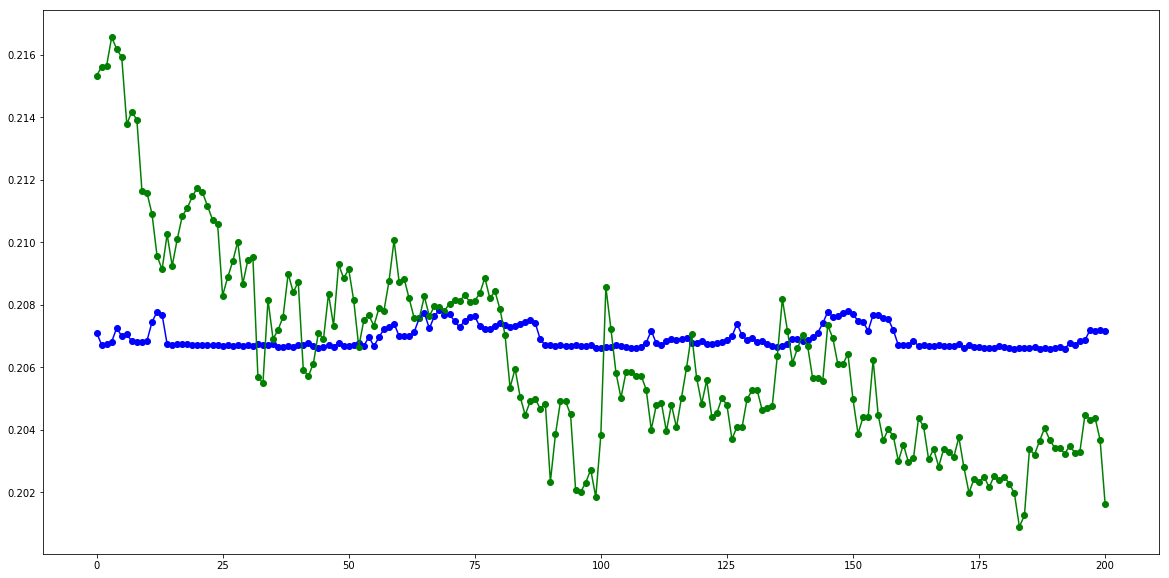

In [18]:
plt.figure(figsize=(20,10))
# visualizer.plot()
# for color in ['blue', 'red']:
# for color in ['red']:
for color in ['blue']:
    color_df = visualizer.date_pred_targ_dict.get(color, pd.DataFrame())
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
#     plt.scatter([color_df.iloc[0,0]], [color_df.iloc[0, -2]*10], color=color)
#     plt.plot([color_df.iloc[0,0]], [color_df.iloc[0, -2]*10], color=color)
#     plt.scatter([color_df.iloc[0,0]], [color_df.iloc[0, -1]*10], color='g')
#     plt.plot([color_df.iloc[0,0]], [color_df.iloc[0, -1]*10], color='g')
plt.show()

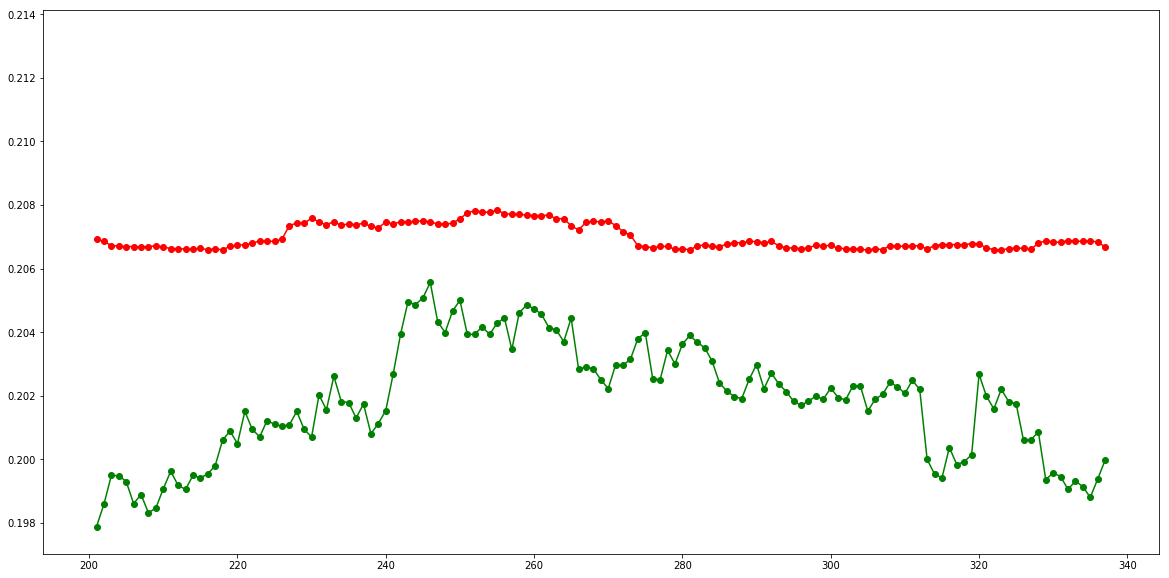

In [19]:
plt.figure(figsize=(20,10))

for color in ['red']:
    color_df = visualizer.date_pred_targ_dict.get(color, pd.DataFrame())
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
#     plt.scatter([color_df.iloc[0,0]], [color_df.iloc[0, -2]*10], color=color)
#     plt.plot([color_df.iloc[0,0]], [color_df.iloc[0, -2]*10], color=color)
#     plt.scatter([color_df.iloc[0,0]], [color_df.iloc[0, -1]*10], color='g')
#     plt.plot([color_df.iloc[0,0]], [color_df.iloc[0, -1]*10], color='g')
plt.show()